# Part 1 #

In [ ]:
import tensorflow as tf

def euclidean_dist(x, z):
  n2 = tf.shape(z)[0]
  x_ = tf.expand_dims(x,len(x.shape))
  # x_ = tf.tile(x_, [1,1, n2]) #optional, will be broadcasted
  z_ = tf.expand_dims(tf.transpose(z),0)
  res = tf.square(x_- z_)
  res = tf.reduce_sum(res, 1)
  return res

# Part 2 #

In [1]:
import numpy as np
def split_data():
  np.random.seed(521)
  Data = np.linspace(1.0, 10.0, num=100)[:, np.newaxis]
  Target = np.sin(Data) + 0.1*np.power(Data,2) + 0.5*np.random.randn(100,1)
  randIdx = np.arange(100)
  np.random.shuffle(randIdx)
  trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
  validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
  testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]
  return trainData, trainTarget, validData, validTarget, testData, testTarget

def getMSETensor(predictions, label):
    N = tf.cast(tf.shape(label)[0],tf.float32)
    mse = 1/(2*N) * tf.reduce_sum(tf.square((predictions-label)))
    return mse

class KNNBuilder:
  def __init__(self, k):
    self.k = k
  def setData(self, trainData, trainTarget, validData, validTarget, testData, testTarget):
    self.trainData = trainData
    self.trainTarget = trainTarget
    self.validData = validData
    self.validTarget = validTarget
    self.testData = testData
    self.testTarget = testTarget
  def build(self):
    tf.reset_default_graph()
    trainData = tf.placeholder(tf.float32, shape=(None, 1), name="trainData")
    trainTarget = tf.placeholder(tf.float32, shape=(None, 1), name="trainTarget")
    
    X = tf.placeholder(tf.float32, shape=(None,1), name="X")
    distances = -euclidean_dist(X,trainData)
    k_neighbors, k_indices = tf.nn.top_k(distances, k=self.k, name="k_neighbors") # size is n*k

    k_indices = tf.expand_dims(k_indices, 2)
    predictions = tf.gather_nd(trainTarget,k_indices)
    predictions = tf.reduce_mean(predictions, 1)
    
    X_labels = tf.placeholder(tf.float32, shape=(None,1), name="label")
    mse = getMSETensor(predictions, X_labels)
    
    return predictions, mse

In [2]:
trainData1, trainTarget1, validData1, validTarget1, testData1, testTarget1 = split_data() 
data1 = [trainData1, trainTarget1, validData1, validTarget1, testData1, testTarget1]

In [33]:
feed_dict_valid={'X:0':validData1, 'label:0': validTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
feed_dict_test={'X:0':testData1, 'label:0': testTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
feed_dict_train={'X:0':trainData1, 'label:0': trainTarget1, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
for i in (1,3,5,50):
    print("At k = {}:".format(i))
    pred,loss = KNNBuilder(i).build()
    sess = tf.Session()
    for case, feed in [('training', feed_dict_train), ('validation', feed_dict_valid), ('testing', feed_dict_test)]:
        pred_,loss_=sess.run((pred,loss),feed_dict=feed);
        print("    {} loss: {}".format(case, loss_))

At k = 1:
    training loss: 0.0
    validation loss: 0.27154967188835144
    testing loss: 0.31100401282310486
At k = 3:
    training loss: 0.10524209588766098
    validation loss: 0.32627829909324646
    testing loss: 0.1450919657945633
At k = 5:
    training loss: 0.11854124069213867
    validation loss: 0.3104385435581207
    testing loss: 0.1783265769481659
At k = 50:
    training loss: 1.2480087280273438
    validation loss: 1.2287017107009888
    testing loss: 0.7069347500801086


** From the validation loss result, when k = 1 is the best. However, from the testing loss result, when k - 3 is the best. **

At k = 1: loss is 0.26591402292251587
At k = 3: loss is 0.2175053358078003
At k = 5: loss is 0.2050444632768631
At k = 50: loss is 1.8304029703140259


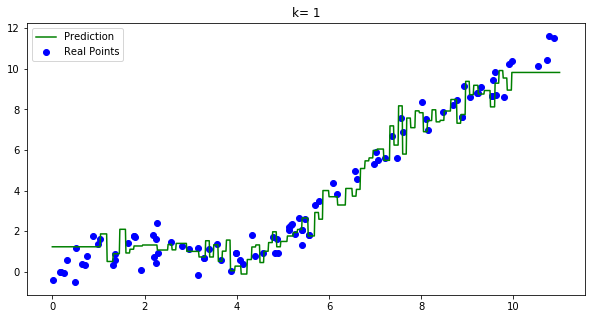

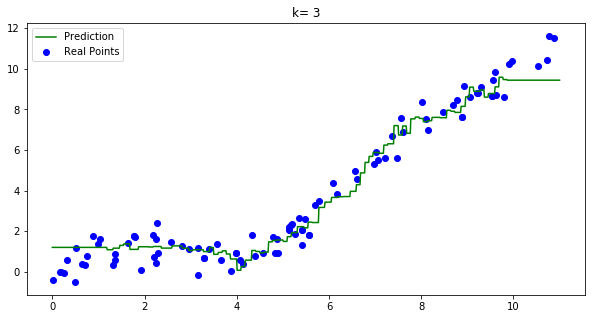

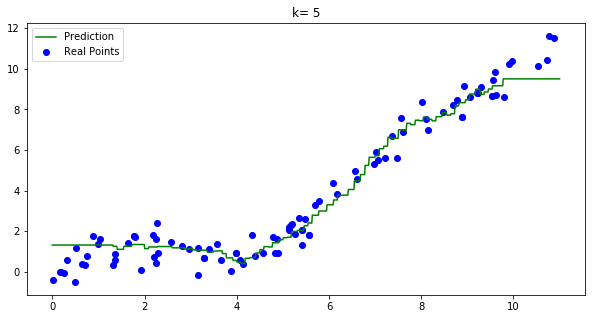

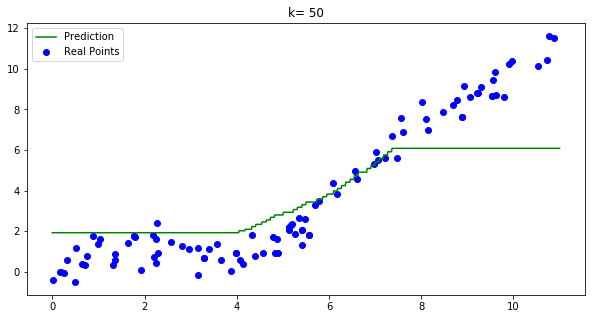

In [151]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random

X = np.linspace(0.0, 11.0, num=1000)[:, np.newaxis]
Target = np.sin( X ) + 0.1 * np.power( X , 2) \
         + 0.5 * np.random.randn(1000 , 1)

randIdx = np.random.randint(0,1000,size = 100)

for i in (1,3,5,50):
    pred,loss = KNNBuilder(i).build()
    sess = tf.Session()
    feed_dict ={'X:0':X, 'label:0': Target, 'trainData:0':trainData1, 'trainTarget:0':trainTarget1}
    pred_,loss_=sess.run((pred,loss),feed_dict=feed_dict);
    print("At k = {}: loss is {}".format(i, loss_))
    plt.figure(figsize=(10,5))
    plt.scatter(X[randIdx],Target[randIdx],c='b',label="Real Points")
    plt.plot(X,pred_,"g", label="Prediction")
    plt.title("k= "+ str(i))
    plt.legend()
    

** From the graphs, when k = 5 it fits the data best and is not overfitting or underfitting as much. **

# Part 3 #

*3.1*

In [76]:
class KNN_classifer_builder:
  def __init__(self, k):
    self.k = k
  def setData(self, trainData, trainTarget, validData, validTarget, testData, testTarget):
    self.trainData = trainData
    self.trainTarget = trainTarget
    self.validData = validData
    self.validTarget = validTarget
    self.testData = testData
    self.testTarget = testTarget
  def build(self):
    tf.reset_default_graph()
    trainData = tf.placeholder(tf.float32, shape=(None, 1024), name="trainData") #n2*1
    trainTarget = tf.placeholder(tf.int32, shape=(None, 1), name="trainTarget")
    X = tf.placeholder(tf.float32, shape=(None, 1024), name="X")
    
    distances = -euclidean_dist(X,trainData) #n1*n2
    k_values, k_indices = tf.nn.top_k(distances, k=self.k, name="k_neighbors") # size is n1*k, choose k indice from n2

    k_indices = tf.expand_dims(k_indices, 2) #traintarget is 2d, so the indice should be 2d, expand k so that each indice is 2d
    predictions = tf.gather_nd(trainTarget,k_indices)
    predictions = tf.squeeze(predictions, 2)
    self.all_predictions = predictions
    return predictions
    #tf.unique_with_counts(predictions)
  def run(self, sess, test):
    feed_dict={tf.get_default_graph().get_tensor_by_name('trainData:0'):self.trainData, \
                        tf.get_default_graph().get_tensor_by_name('trainTarget:0'):self.trainTarget[:,np.newaxis], \
                        tf.get_default_graph().get_tensor_by_name('X:0'):test}

    res = []
    for i in range(test.shape[0]):
        get_counts_i = tf.unique_with_counts(self.all_predictions[i])
        uniques, indices, counts = get_counts_i
        max_i = tf.cast(tf.argmax(counts),tf.int32)
        tmp = uniques[max_i]
        res.append(tmp)
    return sess.run(res, feed_dict=feed_dict)

  def run_k_neighbours(self, testcase):
    tf.reset_default_graph()
    trainData = tf.placeholder(tf.float32, shape=(None, 1024), name="trainData") #n2*1
    trainTarget = tf.placeholder(tf.int32, shape=(None, 1), name="trainTarget")
    X = tf.placeholder(tf.float32, shape=(None, 1024), name="X")
    distances = -euclidean_dist(X,trainData) #n1*n2
    k_dists, k_indices = tf.nn.top_k(distances, k=self.k, name="k_neighbors") # size is n1*k, choose k indice from n2
    sess = tf.Session()
    feed_dict={tf.get_default_graph().get_tensor_by_name('trainData:0'):self.trainData, \
                    tf.get_default_graph().get_tensor_by_name('trainTarget:0'):self.trainTarget[:,np.newaxis], \
                    tf.get_default_graph().get_tensor_by_name('X:0'):testcase}
    return sess.run(k_indices,feed_dict=feed_dict)

*3.2*

In [38]:
def data_segmentation(data_path, target_path, task):
  # task = 0 >> select the name ID targets for face recognition task
  # task = 1 >> select the gender ID targets for gender recognition task
  data = np.load(data_path)/255
  data = np.reshape(data, [-1, 32*32])
  target = np.load(target_path)
  np.random.seed(45689)
  rnd_idx = np.arange(np.shape(data)[0])
  np.random.shuffle(rnd_idx)
  trBatch = int(0.8*len(rnd_idx))
  validBatch = int(0.1*len(rnd_idx))
  trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
          data[rnd_idx[trBatch+1:trBatch+validBatch],:],\
          data[rnd_idx[trBatch+validBatch+1:-1],:]
  trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
          target[rnd_idx[trBatch+1:trBatch+validBatch], task],\
          target[rnd_idx[trBatch+validBatch+1:-1], task]
  return trainData, validData, testData, trainTarget, validTarget, testTarget

trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 0)
data = [trainData, trainTarget, validData, validTarget, testData, testTarget]

In [60]:
def accuracy(predictions, labels):
    p = np.array(predictions)
    l = np.array(labels)
    return p[p == l].size / l.size

In [29]:
for k in [1, 5, 10, 25, 50, 100, 200]:
    knn_c = KNN_classifer_builder(k)
    knn_c.build()
    knn_c.setData(*data)
    sess = tf.Session()
    predictions = knn_c.run(sess, validData)
    acc = accuracy(predictions, validTarget)
    print("k = {}: accuracy is {}.".format(k, acc))

k = 1: accuracy is 0.6630434782608695.
k = 5: accuracy is 0.6086956521739131.
k = 10: accuracy is 0.5760869565217391.
k = 25: accuracy is 0.5978260869565217.
k = 50: accuracy is 0.5760869565217391.
k = 100: accuracy is 0.4782608695652174.
k = 200: accuracy is 0.31521739130434784.


** From the validation results, the best k is when k = 1. **

In [61]:
knn_c = KNN_classifer_builder(1)
knn_c.build()
knn_c.setData(*data)
sess = tf.Session()
preds = knn_c.run(sess, testData)
acc = accuracy(preds, testTarget)
print("k = {}: accuracy is {}.".format(1, acc))

k = 1: accuracy is 0.7096774193548387.


** At k = 1, the accuracy for testing data is 70.97% **

The 7th case from the testing data is predicted wrong, so we decide to use this one to study.

In [122]:
knn_c = KNN_classifer_builder(10)
knn_c.build()
knn_c.setData(*data)
sess = tf.Session()
preds = knn_c.run(sess, testData)
print(preds==testTarget)

[ True False False  True  True False False  True False False  True False
  True False False False  True  True  True False False  True  True  True
  True False False  True  True False  True  True  True  True False False
 False  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True  True False False  True
  True False False  True  True False  True False  True  True  True  True
 False  True  True  True  True False  True  True  True  True  True  True
  True  True  True False  True  True  True False  True]


In [158]:
knn_c = KNN_classifer_builder(10)
knn_c.setData(*data)
indices = knn_c.run_k_neighbours([testData[6]])

plotting the picked wrong-predicted figure

Text(0.5,1,'label is 4')

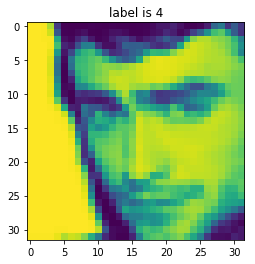

In [146]:
plt.imshow(testData[6].reshape(32,32))
plt.title("label is {}".format(testTarget[6]))

Plotting the 10 nearest neighbours for the picked graph

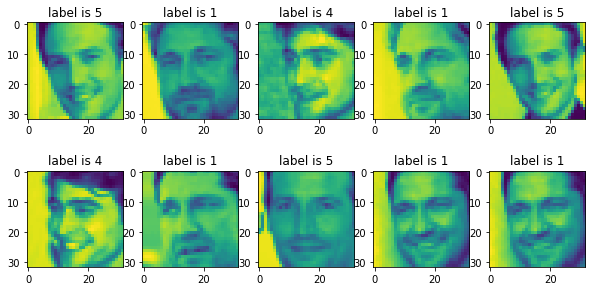

In [147]:
plt.figure(figsize=(10,5))
for i,index in enumerate(indices[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[index].reshape(32,32))
    plt.title("label is {}".format(trainTarget[index]))

**All of these images share similar features. For example, a tilted smiling male face. However, the correct labeled neighbours only account for 2 out of the total 10 images. The facing direction might distract the predictor. **

# 3.3 #

In [152]:
trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 1)
data = [trainData, trainTarget, validData, validTarget, testData, testTarget]

In [153]:
for k in [1, 5, 10, 25, 50, 100, 200]:
    knn_c = KNN_classifer_builder(k)
    knn_c.build()
    knn_c.setData(*data)
    sess = tf.Session()
    predictions = knn_c.run(sess, validData)
    acc = accuracy(predictions, validTarget)
    print("k = {}: accuracy is {}.".format(k, acc))

k = 1: accuracy is 0.9130434782608695.
k = 5: accuracy is 0.9130434782608695.
k = 10: accuracy is 0.8913043478260869.
k = 25: accuracy is 0.9021739130434783.
k = 50: accuracy is 0.8913043478260869.
k = 100: accuracy is 0.8586956521739131.
k = 200: accuracy is 0.782608695652174.


** Now, use the validation data for gender prediction, the best k is 1 and 5. **

In [154]:
knn_c = KNN_classifer_builder(1)
knn_c.build()
knn_c.setData(*data)
sess = tf.Session()
preds = knn_c.run(sess, testData)
acc = accuracy(preds, testTarget)
print("k = {}: accuracy is {}.".format(1, acc))

k = 1: accuracy is 0.9247311827956989.


** At k=1, the accuracy for testing data is 92.47%. The accuracy is pretty high. The classification for gender is a
binary case which is simpler task comparing to the previous one. **

In [156]:
knn_c = KNN_classifer_builder(10)
knn_c.build()
knn_c.setData(*data)
sess = tf.Session()
preds = knn_c.run(sess, testData)
print(preds==testTarget)

[ True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
 False  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True]


In [160]:
knn_c = KNN_classifer_builder(10)
knn_c.setData(*data)
indices = knn_c.run_k_neighbours([testData[1]])

plotting the picked wrong-predicted figure ( index = 1)

Text(0.5,1,'label is 0')

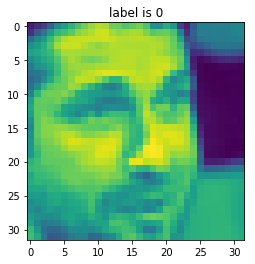

In [164]:
plt.imshow(testData[1].reshape(32,32))
plt.title("label is {}".format(testTarget[1]))

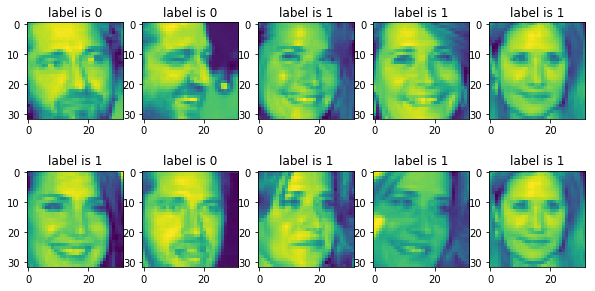

In [165]:
plt.figure(figsize=(10,5))
for i,index in enumerate(indices[0]):
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[index].reshape(32,32))
    plt.title("label is {}".format(trainTarget[index]))

** The voting result is female. Some noise factors such as facing direction might cause distraction. **